## Graph-Based Summarization 圖論摘要方法
Graph-Based Summarization的主要概念是把文章轉換成圖論，然後利用演算法(PageRank)找出最重要和句子來做摘要。在一個文章圖論中，每個節點會代表一個句子，而線段會代表節點/句子之間的相似度(cosine similarity)。一些知名的演算法包括TextRank和LexRank——兩個都利用PageRank的演算法來計算最重要的句子。這個示範會利用到PageRank和cosine similarity，但是不同的演算法和相似度會輸出不同的效果。

PageRank是一Google發展出來的演算法，用來做Google搜尋引擎結果中的網頁進行排名。它的排名方法主要是看一個網頁鏈接的數量和質量來計算一個網站有多重要。PageRank的假設是更重要的網站更有可能會從其它網站獲得更多鏈接(線段)。圖論摘要方法也是依照這個道理計算文章裏重要和適合做摘要的句子。它會找出每個句子之間的相似度，然後依照PageRank的演算法和道理，最重要的句子會最像文章裏的其他句子(最多線段和相似度最高的句子/節點)。除了做單文件摘要，圖論摘要方法也適合做關鍵字萃取和多文件摘要。


圖論摘要方法可以分成幾個主要步驟:
1. 將文本分句
2. 把文本轉換成vector，並利用vector創造一個sparse matrix
3. 計算每個vector的cosine similarity，再創造一個similarity matrix
4. 構建圖論模型，節點為句子，線段為句子之間的cosine similarity
5. 用PageRank演算法取得句子的分數，然後排序並取最高得分的句子作爲摘要

## 讀取資料
- 讀取爬文和下載好的100篇文章

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
news100 = pd.read_excel('appledaily_politinews100.xlsx')

## 清理文集並創建語料庫
- 清理爬下來文集（刪除標點符號，數字，和停止詞）
- 設定/創造詞庫
- 創造語料庫，然後把它轉換成電腦能分析的格式

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import jieba
import jieba.analyse
import re
import networkx as nx

In [4]:
text = news100['content']

# 設定適合的標點符號和停止詞
punctuation = [' ','；','，','。','！','：','「','」','｣','…','、','？','【','】','.',':','?',';','!','~','`','+','-','<','>','/','[',']','{','}',"'",'"',     '\xa0','%','）','（','\u3000','\u200b','\t','／']
#stopwords = {}.fromkeys([ line.rstrip() for line in open('ting_zhi_words.txt', encoding='utf8') ])
stop = requests.get('https://raw.githubusercontent.com/tomlinNTUB/Machine-Learning/master/data/%E5%81%9C%E7%94%A8%E8%A9%9E-%E7%B9%81%E9%AB%94%E4%B8%AD%E6%96%87.txt', verify = False)
stopwords = stop.text.split('\r\n')
addedStops = ['httpswwwfacebookcomappledailytw','nannan','好','已','最']

# 刪除標點符號和數字
cleanText = []
for doc in text:
    onedoc=''
    for char in str(doc).replace('\n',''):
        if char not in punctuation and not char.isdigit() :#and char not in stopwords
            onedoc += char
    cleanText.append(onedoc)

# 設定詞庫和加詞
jieba.set_dictionary('dict.txt.big.txt') # 應用繁體詞庫
jieba.add_word('蔡英文') # 加新詞進入詞庫
jieba.add_word('韓國瑜')
jieba.add_word('柯P')
jieba.add_word('柯文哲')
jieba.add_word('邱豐光')
jieba.add_word('民進黨')
jieba.add_word('國民黨')

# 創造語料庫，刪除停止詞
corpus = [] # 語料庫
for cleanDoc in cleanText:
    textList = jieba.lcut(cleanDoc, cut_all=False)
    noBrakesList = []
    for phrase in textList:
        if phrase not in stopwords and phrase not in addedStops:
            noBrakesList.append(phrase)
    corpus.append(' '.join(noBrakesList))

#corpus

D:\Anaconda3\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
Building prefix dict from C:\Users\YB0002777\Desktop\Learning Python\dict.txt.big.txt ...
Loading model from cache C:\Users\YB0002~1\AppData\Local\Temp\jieba.u018f3a7b0c6b32cba5278025feb505ed.cache
Loading model cost 1.258 seconds.
Prefix dict has been built succesfully.


In [5]:
# 把語料庫和文章轉換成 vector
vect = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b', max_features = 6500)
corpus_tfidf = vect.fit_transform(corpus)
#doc_tfidf = vect.transform([testDoc])

In [6]:
# 語料庫 vector shape
print('Corpus Shape:\t', corpus_tfidf.shape)
#print('Document Shape:\t', doc_tfidf.shape)

Corpus Shape:	 (100, 6500)


In [7]:
# 語料庫最高TF-IDF分數的100個單詞/最重要的單詞
feature_array = np.array(vect.get_feature_names())
tfidf_sorting = np.argsort(corpus_tfidf.toarray()).flatten()[::-1]

n = 100
top_n = feature_array[tfidf_sorting][:n]
top_n

array(['邱豐光', '邱', '開口', '侯', '副', '市長', '目前', '柯文哲', '多以', '邱任', '邱力',
       '人脈廣', '必達', '明升暗降', '搶人', '空穴來風', '商界', '看待', '冀望', '看上', '弟',
       '探詢', '使命', '將於月', '強邱', '調往', '警政', '正式', '王嘉慶', '警', '去年', '警察局',
       '不約而同', '大學', '大戰', '柯侯', '宜', '周刊', '警政署', '人侯友', '副手', '喜歡',
       '各縣市', '私下', '回覆', '來當', '早', '署長', '發現', '一場', '就職', '幕僚', '王',
       '侯友宜', '做好', '柯p', '局長', '綜合', '意願', '議會', '外界', '交換', '前度', '片',
       '邁選', '報導', '效果', '曝光', '挺', '展開', '首長', '協議', '密約', '重要', '找',
       '新北', '君子', '結束', '溝通', '當時', '落幕', '對此', '工作', '選戰', '討論', '決定',
       '台北市', '原本', '參選', '前', '日', '時', '韓國瑜', '月', '當選', '陳', '選舉',
       '知道', '想', '表示'], dtype='<U33')

## Vectorize文章並找出最適合做摘要的句子
- 把文章分成句子
- 把句子轉換成vector，然後計算每個句子的TF-IDF分數

In [8]:
# 選擇文章，把文章分成句子
docNum = 31
testDoc = news100['content'][docNum]
testTitle = news100['title'][docNum]

def splitSentences(document):
    #for sent in re.findall(u'[^!?。\.\!\?]+[!?。\.\!\?]?', paragraph, flags=re.U):
    for sent in re.findall(u'[^!?。\!\?]+[!?。\!\?]?', document, flags=re.U):
        yield sent

sentenceDoc = []
for sent in list(splitSentences(testDoc))[:-1]:
    sentenceDoc.append(' '.join(jieba.cut(sent)))

# 原本文章
testDoc

'今年九合一大選投票狀況多，據了解，中選會官方網站在投票日當天曾遭到來自境外大規模分散式阻斷服務（DD0oS）攻擊，所幸在負責網路維護中華電信應變下，未進一步造成影響。中選會副主委陳朝建今證實曾遭駭客攻擊，不過計票網路是封閉系統，並非公開網路，無法由外界接取，因此沒有任何影響，境外網路干擾也並未影響投票進程。行政院發言人Kolas Yotaka（谷辣斯・尤達卡）表示，中選會在選前即做好縝密防護，因此成功防堵攻擊，接下來將針對有形的選務如投票排隊問題，以及無形的選務如資安防護進行檢討。不過，投票日當天開票進程緩慢，台北市選情更創下史上第一次開票長達9小時的紀錄，陳朝建說明，開票時間長是因為投票時間延後，計票不受駭客影響，開票也自然不受此影響。據內部消息指出，投票日當天曾出現從境外進行分散式阻斷服務（DDoS）攻擊，企圖癱瘓中選會網站，不過在中華電信、中選會緊急處理後，阻斷來自國外異常流量，在短時間獲得解決，一般民眾並沒有發現特殊異樣。NCC及中華電信暫未對此做進一步說明。陳朝建表示，受攻擊的是中選會官方網站，當日開票的計票網路是獨立的封閉網路，並非公開網路，無法由外界接取，完全未有任何影響；中華電信團隊也是24小時監控與防護作業，也沒有受到任何影響。陳朝建說，受到攻擊的官網，當日皆有隨時防衛，中華電信團隊24小時監控與防護作業；故當日遭到來自境外大規模分散式阻斷服務（DD0oS）攻擊時，在負責網路維護中華電信的緊急應變下，並沒有受到影響。另外，Kolas表示，中選會的官網在選舉當天上午6時56分至7時01分期間，遭受大規模境外DDoS攻擊，而中選會的系統是封閉系統，防護非常嚴密，因此沒被攻擊，而當因中選會在選前即做好縝密的防護，當天其實沒因網路攻擊發生意外狀況，中選會的資安管理有成功防堵攻擊。Kolas表示，所幸這次在事前有預見可能的危險，中選會的資料庫、網站等都沒遭受損害，而在資訊時代，行政院希望在這波中選會的選務檢討中，不只針對有形被詬病的排隊投票問題，無形的選務如資安防護，也會進行檢討、加強。（林惟崧、鄭鴻達／台北報導）出版：1454更新：1942（新增行政院說法） \xa0想知道更多，一定要看……【獨家】投票日遭境外駭客攻擊\u3000中選會網站險癱瘓看了這則新聞的人，也看了……老里長險勝1票\u3000美女里長候選人要求驗票發祭品囉！\u3000韓總雞排逾千

In [9]:
# 分詞後的文章
sentenceDoc

['今年 九 合一 大選 投票 狀況 多 ， 據 了解 ， 中選會 官方網站 在 投票 日 當天 曾 遭到 來自 境外 大規模 分散式 阻斷 服務 （ DD0oS ） 攻擊 ， 所幸 在 負責 網路 維護 中華電信 應變 下 ， 未 進一步 造成 影響 。',
 '中選會 副 主委 陳 朝 建今 證實 曾 遭 駭客 攻擊 ， 不過 計票 網路 是 封閉系統 ， 並非 公開 網路 ， 無法 由 外界 接取 ， 因此 沒有 任何 影響 ， 境外 網路 干擾 也 並未 影響 投票 進程 。',
 '行政院 發言人 Kolas   Yotaka （ 谷辣斯 ・ 尤 達卡 ） 表示 ， 中選會 在 選前 即 做好 縝密 防護 ， 因此 成功 防堵 攻擊 ， 接下來 將 針對 有形 的 選務 如 投票 排隊 問題 ， 以及 無形 的 選務 如資安 防護 進行 檢討 。',
 '不過 ， 投票 日 當天 開票 進程 緩慢 ， 台北市 選情 更 創下 史上 第一次 開票 長達 9 小時 的 紀錄 ， 陳 朝建 說明 ， 開票 時間 長 是 因為 投票 時間 延後 ， 計票 不 受 駭客 影響 ， 開票 也 自然 不受 此 影響 。',
 '據 內部消息 指出 ， 投票 日 當天 曾 出現 從 境外 進行 分散式 阻斷 服務 （ DDoS ） 攻擊 ， 企圖 癱瘓 中選會 網站 ， 不過 在 中華電信 、 中選會 緊急 處理 後 ， 阻斷 來自 國外 異常 流量 ， 在 短時間 獲得 解決 ， 一般 民眾並 沒有 發現 特殊 異樣 。',
 'NCC 及 中華電信 暫未 對此 做 進一步 說明 。',
 '陳 朝建 表示 ， 受 攻擊 的 是 中選會 官方網站 ， 當日 開票 的 計票 網路 是 獨立 的 封閉 網路 ， 並非 公開 網路 ， 無法 由 外界 接取 ， 完全 未有 任何 影響 ； 中華電信 團隊 也 是 24 小時 監控 與 防護 作業 ， 也 沒有 受到 任何 影響 。',
 '陳 朝建 說 ， 受到 攻擊 的 官網 ， 當日 皆 有 隨時 防衛 ， 中華電信 團隊 24 小時 監控 與 防護 作業 ； 故 當日 遭到 來自 境外 大規模 分散式 阻斷 服務 （ DD0oS ） 攻擊 時 ， 在 負責 網路 維護 中華電信 的 緊急 應變 下 ， 並 沒有 受到 影

In [10]:
# 把文章轉換成 vector，並創造一個 sparse matrix
doctor_tfidf = vect.transform(sentenceDoc)
doctor_tfidf

<10x6500 sparse matrix of type '<class 'numpy.float64'>'
	with 263 stored elements in Compressed Sparse Row format>

## 計算句子相似度
- 把文章轉換成 vector 以後可以用來計算句子之間的相似度依照TF-IDF分數(cosine similarity)
- 用 cosine similarity 創造 similarity matrix

In [11]:
# 創造空的 similarity matrix (相似度矩陣)
sim_matrix = np.zeros([len(sentenceDoc), len(sentenceDoc)])
sim_matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [12]:
# 用 cosine similarity 計算文章句子之間的相似度，並把空的 similarity matrix 填滿
for i in range(len(sentenceDoc)):
    for j in range(len(sentenceDoc)):
        if i != j:
            sim_matrix[i][j] = cosine_similarity(doctor_tfidf[i], doctor_tfidf[j])[0,0]
            #sim_matrix[i][j] = cosine_similarity(doctor_tfidf[i].reshape(1,100), doctor_tfidf[j].reshape(1,100))[0,0]

sim_matrix

array([[0.        , 0.28932826, 0.07071838, 0.12412599, 0.40618577,
        0.16729712, 0.28698711, 0.5139728 , 0.28538874, 0.09787338],
       [0.28932826, 0.        , 0.05486499, 0.21259262, 0.10609694,
        0.        , 0.55933654, 0.20667443, 0.26784045, 0.04087918],
       [0.07071838, 0.05486499, 0.        , 0.02112692, 0.07366853,
        0.        , 0.1397056 , 0.12862096, 0.42785049, 0.53365807],
       [0.12412599, 0.21259262, 0.02112692, 0.        , 0.04841702,
        0.03906373, 0.24261615, 0.0947003 , 0.03329598, 0.01936448],
       [0.40618577, 0.10609694, 0.07366853, 0.04841702, 0.        ,
        0.08106393, 0.08295373, 0.31567354, 0.23925864, 0.10862471],
       [0.16729712, 0.        , 0.        , 0.03906373, 0.08106393,
        0.        , 0.08336997, 0.14799011, 0.        , 0.        ],
       [0.28698711, 0.55933654, 0.1397056 , 0.24261615, 0.08295373,
        0.08336997, 0.        , 0.4983989 , 0.25687401, 0.07563192],
       [0.5139728 , 0.20667443, 0.1286209

## 構建圖論並應用PageRank演算法
- 把創造好的similarity matrix畫成圖論，再用PageRank找出最重要的句子

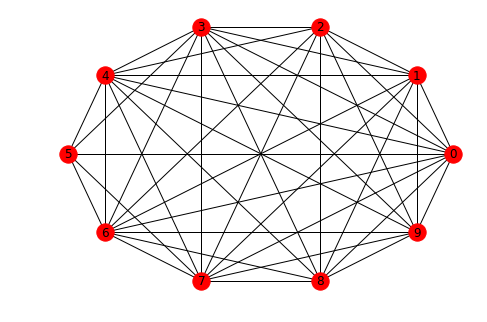

In [14]:
# 把 similarity matrix 變成成圖論（節點代表句子，線段代表相似度）
nx_graph = nx.from_numpy_array(sim_matrix)
nx.draw_circular(nx_graph, with_labels=True)

In [15]:
# 轉換成圖論後再用 PageRank 演算法找出最重要的句子
scores = nx.pagerank(nx_graph)
scores

{0: 0.13643716537803235,
 1: 0.1069935473146541,
 2: 0.09277224040681233,
 3: 0.059179207114872165,
 4: 0.09305402631165097,
 5: 0.04228665394768518,
 6: 0.13470992339887847,
 7: 0.13568615148632335,
 8: 0.12321699784293326,
 9: 0.0756640867981581}

In [16]:
# 最重要的三個句子
from collections import Counter
c = Counter(scores)
c.most_common(3)

[(0, 0.13643716537803235), (7, 0.13568615148632335), (6, 0.13470992339887847)]

## 長文摘要
- 從PageRank的結果中找出最適合做摘要的句子

In [17]:
# 找出 PageRank 算最重要的三個句子做摘要
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentenceDoc)), reverse=True)

summarySentences = []
for i in range(3):
    summarySentences.append(ranked_sentences[i][1])

print('標題: ' + '《' + testTitle + '》')
for sentence in sorted(summarySentences):
    print('Sentence ' + str(sentenceDoc.index(sentence)) + '\n', sentence.replace(' ','').strip())

標題: 《中選會證實投票日遭駭客攻擊　行政院：成功防堵》
Sentence 0
 今年九合一大選投票狀況多，據了解，中選會官方網站在投票日當天曾遭到來自境外大規模分散式阻斷服務（DD0oS）攻擊，所幸在負責網路維護中華電信應變下，未進一步造成影響。
Sentence 6
 陳朝建表示，受攻擊的是中選會官方網站，當日開票的計票網路是獨立的封閉網路，並非公開網路，無法由外界接取，完全未有任何影響；中華電信團隊也是24小時監控與防護作業，也沒有受到任何影響。
Sentence 7
 陳朝建說，受到攻擊的官網，當日皆有隨時防衛，中華電信團隊24小時監控與防護作業；故當日遭到來自境外大規模分散式阻斷服務（DD0oS）攻擊時，在負責網路維護中華電信的緊急應變下，並沒有受到影響。


**會提高摘要效果的改進**
1. 更進階的方法計算句子的重要性
    - word embeddings (e.g. word2vec)
2. 更好的分詞/分句子，詞庫，和語料庫會有更好的效果/摘要
3. 利用同義詞加強詞庫
4. 不管是单词还是句子，相似度计算太表面的話，没有涉及到语义层面，效果肯定不会太好。（原因是sentence vector的质量不高，但是word vector的质量非常高）
5. 句子得分模型太过粗糙了，没有考虑feature，得到的效果感觉不会很好。